## Imports

In [1243]:
import pandas as pd
import yfinance as yf
import numpy as np
import time
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import math
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import warnings
from tqdm.notebook import tqdm
from itertools import islice

warnings.simplefilter(action='ignore', category=FutureWarning)

## Functions

### Download Data

In [123]:
def download_data(symbols, period, interval, batch_size=100, delay=0.1):
    """
    This function is used to download data for general purposes in a specified format.

    Parameter:
        symbols (list): List of symbols to download data for.
        period (str): Period to download data for. Number + timeframe(d for day, h for hour, m for minute etc.).
        interval (str): Candlesticks timeframe. Same format as period.
        batch_size (int): Size of the batch. Not to overload scanner.
        delay (int): Seconds to wait after each batch. Not to overload scanner.

    Returns:
        dict: Dictionary in format {symbol: symbol_dataframe}.
        Dataframe contains columns: Datetime, Symbol, Open, High, Low, Close, Volume.
    """
    data = {}

    num_batches = (len(symbols) - 1) // batch_size + 1
    for i in tqdm(range(0, len(symbols), batch_size), desc="Downloading batches", total=num_batches):
        batch = symbols[i:i + batch_size]

        df = yf.download(batch, period=period, interval=interval, group_by="ticker", progress=False, threads=True, ignore_tz=True, auto_adjust=False)

        if df.empty:
            continue

        df = pd.concat([df.reset_index()], axis=1)
        df = df.reset_index(drop=True)

        # Rename columns if multi-ticker
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [
                f"{symbol}_{field}" if field else "Datetime"
                for symbol, field in df.columns
            ]
        else:
            df.columns = [
                f"{batch[0]}_{col}" if col != "Datetime" else "Datetime"
                for col in df.columns
            ]

        # Separate data per ticker
        for symbol in batch:
            selected_columns = [col for col in df.columns if col.startswith(f"{symbol}_")]
            if not selected_columns:
                continue
            symbol_df = df[["Datetime"] + selected_columns].copy()
            symbol_df.columns = [col.split("_", 1)[1] if "_" in col else col for col in symbol_df.columns]
            symbol_df["Symbol"] = symbol
            data[symbol] = symbol_df

        time.sleep(delay)
        
    return data

### Calculate Indicators

In [127]:
def calculate_ema(df, period):
    """
    Calculate a single EMA and return the series.
    Only calculate EMA after enough rows exist (period-1 rows will be NaN).
    """
    ema_series = df["Close"].ewm(span=period, adjust=False).mean()
    ema_series.iloc[:period-1] = pd.NA  # Optional: NaN for initial rows
    return ema_series

def calculate_atr(df, period=14):
    """
    Calculate ATR and ATR%
    """
    high_low = df["High"] - df["Low"]
    high_close = (df["High"] - df["Close"].shift()).abs()
    low_close = (df["Low"] - df["Close"].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df["ATR_14"] = tr.rolling(period).mean()
    df["ATR%"] = df["ATR_14"] / df["Close"] * 100
    return df

def calculate_macd(df):
    """
    Calculate MACD indicators
    """
    ema12 = df["Close"].ewm(span=12, adjust=False).mean()
    ema26 = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = ema12 - ema26
    df["MACD_Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()
    df["MACD_Hist"] = df["MACD"] - df["MACD_Signal"]
    return df

def label_candle_color(df):
    """
    Label candles as Green, Red, or Doji
    """
    df["Candle_Color"] = df.apply(
        lambda row: "Green" if row["Close"] > row["Open"]
        else ("Red" if row["Close"] < row["Open"] else "Doji"),
        axis=1
    )
    return df

def mark_crossovers(df, short_ema, long_ema):
    """
    Mark crossovers between two EMA columns.
    True  = short_ema crosses above long_ema
    False = short_ema crosses below long_ema
    NaN   = all other cases
    """
    col = f"EMA_Crossover_{short_ema}_{long_ema}"
    cross_up = (df[f"EMA_{short_ema}"] > df[f"EMA_{long_ema}"]) & (
        df[f"EMA_{short_ema}"].shift(1) <= df[f"EMA_{long_ema}"].shift(1)
    )
    cross_down = (df[f"EMA_{short_ema}"] < df[f"EMA_{long_ema}"]) & (
        df[f"EMA_{short_ema}"].shift(1) >= df[f"EMA_{long_ema}"].shift(1)
    )

    df[col] = pd.Series('No', index=df.index, dtype="object")
    df.loc[cross_up, col] = 'Bullish'
    df.loc[cross_down, col] = 'Bearish'
    return df

def process_symbol_df(symbol_df, ema_periods=[8,20,34,50,200], crossover_emas=[(8, 20)]):
    """
    Round OHLC, force numeric types, and calculate all indicators
    """
    # Ensure numeric
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        if col in symbol_df.columns:
            symbol_df[col] = pd.to_numeric(symbol_df[col], errors='coerce')

    # Round OHLC
    for col in ["Open", "High", "Low", "Close"]:
        symbol_df[col] = symbol_df[col].round(2)

    # Add symbol column
    # symbol_df["Symbol"] = symbol

    # --- Calculate EMAs individually ---
    for period in ema_periods:
        symbol_df[f"EMA_{period}"] = calculate_ema(symbol_df, period)
        symbol_df[f"Above_EMA_{period}"] = symbol_df["Close"] > symbol_df[f"EMA_{period}"]

    # Other indicators
    symbol_df = calculate_atr(symbol_df)
    symbol_df = calculate_macd(symbol_df)
    symbol_df = label_candle_color(symbol_df)
    for ema_1, ema_2 in crossover_emas:
        symbol_df = mark_crossovers(symbol_df, ema_1, ema_2)

    return symbol_df


### Helper Functions

In [92]:
def apply_to_dict(stock_dict, function, **kwargs):
    new_stock_dict = {}
    for sym, df in tqdm(stock_dict.items(), desc="Processing symbols", total=len(stock_dict)):
        df = df.copy()
        df = function(df, **kwargs)
        new_stock_dict[sym] = df
    return new_stock_dict

### Trade Analysis

In [157]:
def generate_trades(df, short_ema: int, long_ema: int):
    trades = []

    # Dynamically pick the crossover column name
    crossover_col = f"EMA_Crossover_{short_ema}_{long_ema}"

    for i in range(1, len(df) - 2):  # leave space for entry day
        prev = df.iloc[i - 1]
        curr = df.iloc[i]
        nxt = df.iloc[i + 1]

        # Detect bullish crossover using precomputed crossover column
        if curr[crossover_col] == 'Bullish' and prev[crossover_col] == 'No':
            entry_day = nxt  # enter next candle
            crossover_day = curr

            # Only enter if new high is made
            if entry_day["High"] > crossover_day["High"]:
                entry_price = crossover_day["High"]
                stop_loss = prev["Low"]  # day before crossover
                risk = entry_price - stop_loss
                pt1 = entry_price + risk
                pt2 = entry_price + 2 * risk

                # Trade outcome flags
                pt1_hit, pt2_hit, stop_loss_hit = False, False, False
                exit_date, exit_price = None, None

                # Track forward until exit
                for j in range(i + 1, len(df)):
                    day = df.iloc[j]

                    # Check PT1
                    if not pt1_hit and day["High"] >= pt1:
                        pt1_hit = True

                    # Check PT2
                    if day["High"] >= pt2:
                        pt2_hit = True
                        exit_date, exit_price = day["Datetime"], pt2
                        break

                    # Check Stop Loss
                    if day["Low"] <= stop_loss:
                        stop_loss_hit = True
                        exit_date, exit_price = day["Datetime"], stop_loss
                        break

                    # Check EMA cross back
                    if day[f"EMA_{short_ema}"] < day[f"EMA_{long_ema}"]:
                        exit_date, exit_price = day["Datetime"], day["Close"]
                        break

                # Crossover metrics
                crossover_vol = crossover_day["Volume"]
                crossover_color = "Bullish" if crossover_day["Close"] > crossover_day["Open"] else "Bearish"

                # Candle color at entry
                candle_color = (
                    "Green" if entry_day["Close"] > entry_day["Open"]
                    else "Red" if entry_day["Close"] < entry_day["Open"]
                    else "Doji"
                )

                # ATR %
                atr_pct = entry_day["ATR_14"] / entry_day["Close"] * 100

                # Append trade
                trades.append({
                    "Datetime": entry_day["Datetime"],
                    "Symbol": df['Symbol'].values[0],
                    "Crossover_Volume": crossover_vol,
                    "Crossover_Color": crossover_color,
                    "Entry Price": entry_price,
                    "Stop Loss": stop_loss,
                    "PT1": pt1,
                    "PT2": pt2,
                    "PT1_Hit": pt1_hit,
                    "PT2_Hit": pt2_hit,
                    "Stop_Loss_Hit": stop_loss_hit,
                    "Exit Date": exit_date,
                    "Exit Price": exit_price,
                })

    trades = pd.DataFrame(trades)
    try:
        trades = pd.merge(trades, df, on=["Datetime", "Symbol"], how="left")
    except Exception as e:
        print(f"Merge error for symbol {df['Symbol'].values[0]}: {e}")

    return trades

## Explore Trades

In [61]:
symbols_data = pd.read_csv('data/all_symbols_results_june_2025.csv', index_col=0).dropna().reset_index(drop=True)
symbols_list = list(symbols_data['Symbol'])

In [81]:
stock_data = download_data(symbols=symbols_list, period='1000d', interval='1d')

Processing batch 1 of 55
Processing batch 2 of 55
Processing batch 3 of 55
Processing batch 4 of 55
Processing batch 5 of 55
Processing batch 6 of 55



2 Failed downloads:
['JNPR', 'X']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 7 of 55



1 Failed download:
['AZEK']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 8 of 55
Processing batch 9 of 55
Processing batch 10 of 55
Processing batch 11 of 55



1 Failed download:
['DIST']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 12 of 55



8 Failed downloads:
['JVSA', 'OCX']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')
['SNCR', 'NSPR', 'GGR', 'FOSL', 'MAMO']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['VEEA']: Timeout('Failed to perform, curl: (28) Operation timed out after 10001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Processing batch 13 of 55
Processing batch 14 of 55



1 Failed download:
['KRON']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 15 of 55
Processing batch 16 of 55
Processing batch 17 of 55
Processing batch 18 of 55
Processing batch 19 of 55



1 Failed download:
['GLYC']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 20 of 55



2 Failed downloads:
['EYEN', 'CEAD']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 21 of 55



3 Failed downloads:
['SNPX', 'FMTO', 'LDTC']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 22 of 55



2 Failed downloads:
['KWE', 'MRIN']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 23 of 55



2 Failed downloads:
['SVT', 'SATX']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 24 of 55



1 Failed download:
['CHRO']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 25 of 55



1 Failed download:
['IGT']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 26 of 55
Processing batch 27 of 55
Processing batch 28 of 55
Processing batch 29 of 55



1 Failed download:
['EVRI']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 30 of 55



1 Failed download:
['WEAV']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Processing batch 31 of 55



1 Failed download:
['AGS']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 32 of 55
Processing batch 33 of 55



1 Failed download:
['PHX']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 34 of 55



2 Failed downloads:
['BPT', 'SUP']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 35 of 55
Processing batch 36 of 55



1 Failed download:
['RGLS']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 37 of 55



3 Failed downloads:
['EBTC', 'DADA', 'SHYF']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 38 of 55



1 Failed download:
['LSEA']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 39 of 55



1 Failed download:
['SSBK']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 40 of 55



2 Failed downloads:
['BROG', 'INZY']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 41 of 55
Processing batch 42 of 55
Processing batch 43 of 55
Processing batch 44 of 55
Processing batch 45 of 55
Processing batch 46 of 55
Processing batch 47 of 55
Processing batch 48 of 55



2 Failed downloads:
['LANC', 'ESGR']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 49 of 55



1 Failed download:
['SWTX']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 50 of 55
Processing batch 51 of 55



1 Failed download:
['PLYA']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 52 of 55



1 Failed download:
['RDFN']: YFPricesMissingError('possibly delisted; no price data found  (period=1000d) (Yahoo error = "No data found, symbol may be delisted")')


Processing batch 53 of 55



1 Failed download:
['WBTN']: Timeout('Failed to perform, curl: (28) Operation timed out after 10002 milliseconds with 588 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Processing batch 54 of 55



1 Failed download:
['BRKL']: Timeout('Failed to perform, curl: (28) Operation timed out after 10001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Processing batch 55 of 55


In [131]:
stock_data_labeled = apply_to_dict(stock_data, process_symbol_df)

Processing symbols:   0%|          | 0/5443 [00:00<?, ?it/s]

In [158]:
all_trades = {}
for sym, df in tqdm(stock_data_labeled.items(), desc="Generating trades", total=len(stock_data_labeled)):
    trades_df = generate_trades(df, short_ema=8, long_ema=20)
    all_trades[sym] = trades_df

Generating trades:   0%|          | 0/5443 [00:00<?, ?it/s]

Merge error for symbol X: 'Datetime'
Merge error for symbol JNPR: 'Datetime'
Merge error for symbol AZEK: 'Datetime'
Merge error for symbol HMR: 'Datetime'
Merge error for symbol LHSW: 'Datetime'
Merge error for symbol BKHA: 'Datetime'
Merge error for symbol HSPT: 'Datetime'
Merge error for symbol KIDZ: 'Datetime'
Merge error for symbol FSHP: 'Datetime'
Merge error for symbol DIST: 'Datetime'
Merge error for symbol MAMO: 'Datetime'
Merge error for symbol JVSA: 'Datetime'
Merge error for symbol YHNA: 'Datetime'
Merge error for symbol ASPC: 'Datetime'
Merge error for symbol GGR: 'Datetime'
Merge error for symbol EURK: 'Datetime'
Merge error for symbol RDAC: 'Datetime'
Merge error for symbol OCX: 'Datetime'
Merge error for symbol NSPR: 'Datetime'
Merge error for symbol VEEA: 'Datetime'
Merge error for symbol FOSL: 'Datetime'
Merge error for symbol SNCR: 'Datetime'
Merge error for symbol RCT: 'Datetime'
Merge error for symbol LCCC: 'Datetime'
Merge error for symbol RIBB: 'Datetime'
Merge e

In [159]:
concat_entries = pd.concat([df for df in all_trades.values()])

In [160]:
# Additional thresholds 
min_crossover_vol = 2_000_000 # minimum volume at crossover
min_price = 50 # minimum entry price 

# Filter trades combining trend, volatility, price, volume, and candle color 
filtered_combined = concat_entries[ 
    (concat_entries["Above_EMA_34"]) & # trend filter 
    (concat_entries["ATR%"] < concat_entries["ATR%"].median()) & # low volatility 
    (concat_entries["Entry Price"] >= min_price) & # price filter 
    (concat_entries["Crossover_Volume"] >= min_crossover_vol) 
] 

print("Filtered trades:", len(filtered_combined))
print(filtered_combined[["PT1_Hit", "PT2_Hit", "Stop_Loss_Hit"]].mean())

Filtered trades: 2299
PT1_Hit          0.538495
PT2_Hit          0.347977
Stop_Loss_Hit    0.461505
dtype: float64


#### Best filters are:
1. Above 34 EMA
2. Lower volatility: ATR less than 0.035494516184041786
3. Entry Price higher than 50
4. Volume on crossover candle 50

In [538]:
selected_stocks = filtered_combined['Symbol'].unique() # [:50]
selected_stock_data = {key: value for key, value in stock_data_labeled.items() if key in selected_stocks}

## Grid Search of Trading Parameters

### Functions

In [1211]:
def bullish_bearish_pairs(df, short_ema, long_ema):
    col = f'EMA_Crossover_{short_ema}_{long_ema}'
    
    bullish_indices = df.index[df[col] == "Bullish"].tolist()
    bearish_indices = df.index[df[col] == "Bearish"].tolist()

    # Remove first Bearish if it comes before first Bullish
    if bearish_indices and bullish_indices and bearish_indices[0] < bullish_indices[0]:
        bearish_indices.pop(0)

    # Add last index if no Bearish exists after last Bullish
    if bullish_indices and (not bearish_indices or bearish_indices[-1] < bullish_indices[-1]):
        bearish_indices.append(df.index[-1])

    # Pair them one by one
    pairs = list(zip(bullish_indices, bearish_indices))

    # Ensure all pairs are valid (first < second)
    pairs = [(b, r) for b, r in pairs if b < r]

    return pairs

def simulate_trades(df, short_ema, long_ema, stop_rule, sl_offset_pc, max_tp):
    trades = []

    pairs = bullish_bearish_pairs(df, short_ema, long_ema)
    for bull_cross, bear_cross in pairs:
        # Define trade parameters
        trade = {'Symbol': df['Symbol'].values[0], 'stop_rule': stop_rule, 'offset': sl_offset_pc, 'max_tp': max_tp}
        
        # Select days
        pre_cross_day = df.iloc[bull_cross - 1]
        bull_cross_day = df.iloc[bull_cross]
        entry_day = df.iloc[bull_cross + 1] if bull_cross + 1 < len(df) else None

        # Set entry price
        entry_price = bull_cross_day["High"] if entry_day["High"] > bull_cross_day["High"] else None

        # Only enter if new high is made and entry day is not the tail
        if entry_day is None or entry_price is None:
            continue

        # Set stop loss based on rule
        if stop_rule == "crossover":
            stop_loss = bull_cross_day["Low"]
        elif stop_rule == "previous":
            stop_loss = pre_cross_day["Low"]
        else:
            raise ValueError("Invalid stop rule")
        
        # Apply stop loss offset
        stop_loss -= sl_offset_pc / 100 * (entry_price - stop_loss)

        # Filter out trades with invalid stop loss
        if stop_loss >= entry_price:
            continue

        # Calculate risk
        risk = entry_price - stop_loss

        # Set take profit levels, exit sizes and be price
        tp_levels = [entry_price + (i + 1) * risk for i in range(max_tp)]
        # tp_sizes = [1.0 / max_tp] * max_tp  # Position sizes for each TP level
        # tp_sizes = tp_distribution(max_tp, coefficient=tp_coef)  # Position sizes for each TP level
        be_price = entry_price # + be_level * risk if be_level > 0 else None

        # Set other trade parameters
        trade['Datetime'] = entry_day["Datetime"]
        trade['EntryPrice'] = entry_price
        trade['StopLoss'] = stop_loss
        trade['Risk'] = risk
        trade['MaxTP'] = tp_levels[-1]
        trade['CrossoverVolume'] = bull_cross_day["Volume"]
        trade['CrossoverColor'] = bull_cross_day["Candle_Color"]
        trade['ExitTypes'] = []
        trade['Exits'] = []
        
        for j in range(bull_cross + 1, bear_cross + 1):
            last_tp_hit = False
            day = df.iloc[j]

            # Check stop loss hit
            if day["Low"] <= stop_loss:
                # Set type based on stop loss relation to entry
                if stop_loss > entry_price:
                    exit_type = 'Trailing_SL'
                elif stop_loss < entry_price:
                    exit_type = 'SL'
                else:
                    exit_type = 'BE'
                trade['ExitTypes'].append(exit_type)
                trade['Exits'].append({'Type': exit_type, 'Date': day["Datetime"], 'Price': stop_loss})
                break

            # Check take profit hits
            for idx, tp in enumerate(tp_levels):
                if day["High"] >= tp:
                    if f'TP{idx+1}' not in trade['ExitTypes']:
                        trade['ExitTypes'].append(f'TP{idx+1}')
                        trade['Exits'].append({'Type': f'TP{idx+1}', 'Date': day["Datetime"], 'Price': tp})
                        stop_loss = tp - 2 * risk if idx >= 1 else be_price
                        # Exit if last TP hit
                        if idx + 1 == max_tp:
                            last_tp_hit = True
                            break  # exit TP loop
            if last_tp_hit:
                break

            if j == bear_cross:
                trade['ExitTypes'].append('EMA_Cross')
                trade['Exits'].append({'Type': 'EMA_Cross', 'Date': day["Datetime"], 'Price': day["Close"]})
                break

        trades.append(trade)
    return trades

In [1214]:
def flatten_all_results(all_results):
    flattened = []

    for sym, sym_trades_out in all_results.items():
        for sym_trades_in in sym_trades_out:
            for trade in sym_trades_in:  # each trade is a dict
                for exit_info in trade["Exits"]:
                    row = {
                        "Symbol": trade["Symbol"],
                        "stop_rule": trade["stop_rule"],
                        "offset": trade["offset"],
                        "max_tp": trade["max_tp"],
                        # "breakeven": trade["breakeven"],
                        # "tp_coef": trade["tp_coef"],
                        "Datetime": trade["Datetime"],
                        "EntryPrice": trade["EntryPrice"],
                        "Risk": trade["Risk"],
                        "StopLoss": trade["StopLoss"],
                        "MaxTP": trade["MaxTP"],
                        "CrossoverVolume": trade.get("CrossoverVolume", None),
                        "CrossoverColor": trade.get("CrossoverColor", None),
                        "ExitType": exit_info["Type"],
                        "ExitDate": exit_info["Date"],
                        "ExitPrice": exit_info["Price"],
                        # "ExitSize": exit_info["Size"],
                    }
                    flattened.append(row)

    return pd.DataFrame(flattened)

In [1259]:
def tp_distribution(max_tp, skip_tp=0, coef=1.0):
    """
    Geometric distribution of TP sizes.
    """
    weights = np.array([coef**i for i in range(max_tp-skip_tp)])
    weights = weights / weights.sum()
    weights = [0.0 for i in range(skip_tp)] + weights.tolist()
    return weights

def manage_entries_and_exits(flattened_df, group_cols, skip_tp=0, tp_coef=1.0, add_at_tp=False, add_size=0.0):

    df = flattened_df.copy()
    df["ExitSize"] = 0.0
    df["tp_coef"] = tp_coef
    df["skip_tp"] = skip_tp
    df['add_at_tp'] = add_at_tp
    df['add_size'] = add_size

    # Process each trade separately
    for trade_id, group in df.groupby(group_cols):
        max_tp = group["max_tp"].iloc[0]

        # Generate full TP distribution
        tp_sizes = tp_distribution(max_tp, skip_tp, coef=tp_coef)
        tp_counter = 0
        current_position = 1.0  # start with full initial position
        remaining_tps = list(tp_sizes)  # copy to recalc dynamically

        for idx, row in group.iterrows():
            exit_size = 0.0
            if row["ExitType"].startswith("TP"):
                tp_idx = int(row["ExitType"][2:]) - 1
                if add_at_tp > 0 and tp_idx + 1 == add_at_tp:
                    current_position += add_size

                    # Redistribute remaining TP sizes proportionally
                    unsold_tps = remaining_tps[tp_idx:]  # TPs after current
                    unsold_sum = sum(unsold_tps)
                    if unsold_sum > 0:
                        remaining_tps[tp_idx:] = [x / unsold_sum * (current_position - sum(remaining_tps[:tp_idx])) for x in unsold_tps]

                # Sell current TP
                exit_size = remaining_tps[tp_idx]
                remaining_tps[tp_idx] = 0.0  # mark as sold
                tp_counter += 1

            elif row["ExitType"] in ["SL", "BE", "Trailing_SL", "EMA_Cross"]:
                # Whatever is left after all TPs
                exit_size = sum(remaining_tps)  # all remaining unsold TPs + added position

            df.at[idx, "ExitSize"] = exit_size

    return df

def aggregate_trade(group):
    # Skip trade if any exit price is NaN
    if group["ExitPrice"].isna().any():
        return pd.Series({
            "WeightedExitPrice": np.nan,
            "Return%": np.nan,
            "R_Multiple": np.nan,
            "ExitDate": pd.NaT,
            "ExitTypes": None
        })

    # Total position size for normalization
    total_position = group["ExitSize"].sum()
    if total_position == 0:
        total_position = 1.0  # avoid division by zero
    
    # Weighted average exit price
    weighted_exit_price = (group["ExitPrice"] * group["ExitSize"]).sum() / total_position
    
    entry_price = group["EntryPrice"].iloc[0]
    risk = group["Risk"].iloc[0]
    
    # Calculate aggregated results
    return pd.Series({
        "WeightedExitPrice": weighted_exit_price,
        "Return%": (weighted_exit_price - entry_price) / entry_price * 100,
        "R_Multiple": (weighted_exit_price - entry_price) / risk,
        "ExitDate": group["ExitDate"].max(),  # last exit date
        "ExitTypes": ",".join(group["ExitType"].tolist())  # track what exits happened
    })

In [1209]:
def levels_grid_search(df, stop_rules, offsets, tp_levels):
    all_trades = []

    # Iterate through all parameter combinations
    for stop_rule, offset, tp_level in itertools.product(stop_rules, offsets, tp_levels):

        # Run simulation
        trades_from_df = simulate_trades(df, 8, 20, stop_rule, offset, tp_level)

        all_trades.append(trades_from_df)

    return all_trades

def position_grid_search(df_exits, group_cols, skip_tps, tp_coefs, add_at_tps, add_sizes):
    position_grid_df = pd.DataFrame()

    for skip_tp, tp_coef, add_at_tp, add_size in tqdm(
        itertools.product(skip_tps, tp_coefs, add_at_tps, add_sizes),
        total=len(skip_tps) * len(tp_coefs) * len(add_at_tps) * len(add_sizes)
    ):
        df_exits_temp = manage_entries_and_exits(
            df_exits,
            group_cols,
            skip_tp=skip_tp,
            tp_coef=tp_coef,
            add_at_tp=add_at_tp,
            add_size=add_size
        )
        position_grid_df = pd.concat([position_grid_df, df_exits_temp], ignore_index=True)

    return position_grid_df

In [1187]:
def add_indicators_to_trades(trades_df, historical_data_dict):
    enriched_trades = []

    for _, trade in trades_df.iterrows():
        sym = trade["Symbol"]
        dt = trade["Datetime"]

        # start with trade row
        row = trade.to_dict()

        # lookup historical dataframe for this symbol
        if sym in historical_data_dict:
            hist_df = historical_data_dict[sym]
            match = hist_df.loc[hist_df["Datetime"] == dt]

            if not match.empty:
                # take the first row of matching historical data
                hist_data = match.iloc[0].to_dict()

                # merge into trade row
                row.update(hist_data)

        enriched_trades.append(row)

    return pd.DataFrame(enriched_trades)

### Experiments

In [1212]:
# Define parameter grid
stop_rules = ["crossover"] # crossover is the best option
offsets = [-30, -20, -10, 0, 10, 20, 30] # not a big impact, should experiment with higher range
tp_levels = [5, 6] # 6 is the best option from 1 to 6, but time in the trade increases

# Run grid search across all selected stocks
all_results = {}

stock_dict = stock_data_labeled

for symbol, df in tqdm(stock_dict.items(), desc="Grid search by symbol", total=len(stock_dict)):
    trades = levels_grid_search(df, stop_rules, offsets, tp_levels)
    all_results[df['Symbol'].values[0]] = trades

Grid search by symbol:   0%|          | 0/5443 [00:00<?, ?it/s]

In [1260]:
df_exits = flatten_all_results(all_results)

In [1261]:
# Group by identifying columns that define a unique trade
group_cols = [
    "Symbol", "stop_rule", "offset", "max_tp", "Datetime",
    "EntryPrice", "Risk", "StopLoss", "MaxTP", "CrossoverVolume", "CrossoverColor"
]

tp_coefs = [2.0] # [1.8, 2.0, 2.2, 2.4] # best values above 2.0, then low impact
skip_tps = [0] # [0, 1, 2, 3]
add_at_tps = [0] # [0, 1, 2, 3, 4]
add_sizes = [0] # [0.25, 0.5, 0.75, 1]
position_grid_df = pd.DataFrame()

position_grid_df = position_grid_search(df_exits, group_cols, skip_tps, tp_coefs, add_at_tps, add_sizes)

  0%|          | 0/1 [00:00<?, ?it/s]

In [1262]:
tp_grid = True
group_cols = group_cols + (["tp_coef", "skip_tp", "add_at_tp", "add_size"] if tp_grid else [])

trades_df = position_grid_df.groupby(group_cols).apply(aggregate_trade).reset_index()

In [1263]:
trades_df_historical = add_indicators_to_trades(trades_df, stock_data_labeled)

In [1277]:
trades_df_historical.to_csv('data/outputs/8-20-ema-cross-16-09-2025.csv', index=False)

In [1264]:
summary = trades_df_historical.groupby(
    ["stop_rule", "offset", "max_tp", "tp_coef", "skip_tp", "add_at_tp", "add_size"]
).agg(EV=("R_Multiple", "mean"),
       Winrate=("Return%", lambda x: (x > 0).mean()),
       Trades=("Return%", "count")).reset_index().sort_values(by="EV", ascending=False)

summary.head()

,stop_rule,offset,max_tp,tp_coef,skip_tp,add_at_tp,add_size,EV,Winrate,Trades
13,crossover,30,6,2.0,0,0,0,0.087880,0.498251,64567
11,crossover,20,6,2.0,0,0,0,0.087004,0.499737,64572
9,crossover,10,6,2.0,0,0,0,0.085806,0.499226,64575
12,crossover,30,5,2.0,0,0,0,0.080858,0.498251,64567
10,crossover,20,5,2.0,0,0,0,0.080245,0.499737,64572


## Indicators correlation with trade outcomes

In [1282]:
trades_df_historical_best_params = trades_df_historical[
    (trades_df_historical["stop_rule"] == "crossover") &
    (trades_df_historical["offset"] == 10) & # low influence, taking most conservative values
    (trades_df_historical["max_tp"] == 6) &
    (trades_df_historical["tp_coef"] == 2.0) &
    (trades_df_historical["skip_tp"] == 0) &
    (trades_df_historical["add_at_tp"] == 0) &
    (trades_df_historical["add_size"] == 0.0)
]

### EMA Position

In [1283]:
ema_cols = ["Above_EMA_8", "Above_EMA_20", "Above_EMA_34", "Above_EMA_50", "Above_EMA_200"]

for col in ema_cols:
    print(f"\nIndicator: {col}")
    print(
        trades_df_historical_best_params.groupby(col)["R_Multiple"]
        .agg(EV="mean", Winrate=lambda x: (x>0).mean(), Trades="count")
    )


Indicator: Above_EMA_8
                   EV   Winrate  Trades
Above_EMA_8                            
False       -0.828754  0.041560    3128
True         0.132362  0.522509   61447

Indicator: Above_EMA_20
                    EV   Winrate  Trades
Above_EMA_20                            
False        -0.834905  0.034050    2790
True          0.127382  0.520219   61785

Indicator: Above_EMA_34
                    EV   Winrate  Trades
Above_EMA_34                            
False        -0.494243  0.211439    6171
True          0.147094  0.529619   58404

Indicator: Above_EMA_50
                    EV   Winrate  Trades
Above_EMA_50                            
False        -0.270079  0.338775   14024
True          0.184537  0.543717   50551

Indicator: Above_EMA_200
                     EV   Winrate  Trades
Above_EMA_200                            
False         -0.008375  0.471147   38334
True           0.223389  0.540225   26241


**All EMAs have have positive correlations with outcomes.**

### MACD

In [1279]:
macd_cols = ["MACD", "MACD_Signal", "MACD_Hist"]

corr_matrix = trades_df_historical_best_params[macd_cols + ["Return%", "R_Multiple"]].corr()
print("\nCorrelation of MACD indicators with trade outcomes:")
print(corr_matrix[["Return%", "R_Multiple"]])


Correlation of MACD indicators with trade outcomes:
              Return%  R_Multiple
MACD        -0.020449   -0.009428
MACD_Signal -0.022102   -0.010318
MACD_Hist    0.022289    0.010462
Return%      1.000000    0.692937
R_Multiple   0.692937    1.000000


**Weak correlation of MACD values and outcomes.**

In [1280]:
def macd_quadrant(row):
    if row["MACD"] > 0 and row["MACD_Signal"] > 0:
        return "Bullish (MACD>0, Signal>0)"
    elif row["MACD"] < 0 and row["MACD_Signal"] < 0:
        return "Bearish (MACD<0, Signal<0)"
    elif row["MACD"] > 0 and row["MACD_Signal"] < 0:
        return "MACD>0, Signal<0"
    elif row["MACD"] < 0 and row["MACD_Signal"] > 0:
        return "MACD<0, Signal>0"
    else:
        return "Neutral/Zero"

In [1281]:
trades_df_historical_best_params["MACD_Quadrant"] = trades_df_historical_best_params.apply(macd_quadrant, axis=1)

quadrant_stats = trades_df_historical_best_params.groupby("MACD_Quadrant").agg(
    EV=("R_Multiple", "mean"),
    Winrate=("R_Multiple", lambda x: (x > 0).mean()),
    Trades=("R_Multiple", "count")
).sort_values("Trades", ascending=False)

print("\nPerformance by MACD/Signal quadrant relative to zero:")
print(quadrant_stats)


Performance by MACD/Signal quadrant relative to zero:
                                  EV   Winrate  Trades
MACD_Quadrant                                         
Bearish (MACD<0, Signal<0) -0.088082  0.430872   25826
MACD>0, Signal<0            0.277222  0.578942   20622
Bullish (MACD>0, Signal>0)  0.121968  0.508952   18019
MACD<0, Signal>0           -0.915669  0.000000     108


**MACD>0 gives a strong edge on stock selection, Signal values should be investigated in the combination with other features.**

### Numerical Columns

In [1276]:
trades_df_historical_best_params = trades_df_historical_best_params.copy()
trades_df_historical_best_params["Win"] = trades_df_historical_best_params["Return%"] > 0

In [1286]:
numeric_cols = ["CrossoverVolume", "ATR%", "EntryPrice", "Risk"]

corr_matrix = trades_df_historical_best_params[numeric_cols + ["Return%", "R_Multiple"]].corr()

print(corr_matrix[["Return%", "R_Multiple"]])

                  Return%  R_Multiple
CrossoverVolume  0.014631    0.012006
ATR%            -0.018366   -0.040420
EntryPrice       0.003052    0.001236
Risk             0.002510    0.001018
Return%          1.000000    0.692937
R_Multiple       0.692937    1.000000


In [1287]:
corr_matrix_spearman = trades_df_historical_best_params[numeric_cols + ["Return%", "R_Multiple"]].corr(method="spearman")

print(corr_matrix_spearman[["Return%", "R_Multiple"]])

                  Return%  R_Multiple
CrossoverVolume  0.066399    0.051114
ATR%            -0.167672   -0.017595
EntryPrice       0.061517   -0.012163
Risk            -0.018063    0.012168
Return%          1.000000    0.899525
R_Multiple       0.899525    1.000000


**Crossover Volume should be investigated with other features.**<br>
**Lower ATR% performs slightly better.**<br>
**Entry Price and Risk should also be investigated with other features.**

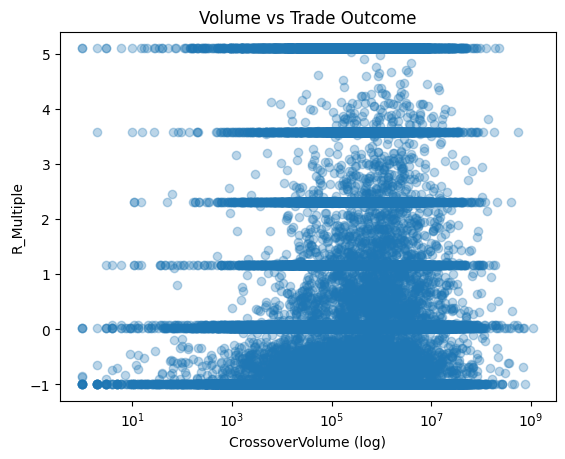

In [1284]:
plt.scatter(trades_df_historical_best_params["CrossoverVolume"], trades_df_historical_best_params["R_Multiple"], alpha=0.3)
plt.xscale("log")
plt.xlabel("CrossoverVolume (log)")
plt.ylabel("R_Multiple")
plt.title("Volume vs Trade Outcome")
plt.show()

**10^5 seems to be a good threshold.**

### Categorical Columns

In [1270]:
trades_df_historical_best_params.groupby("CrossoverColor")["R_Multiple"].agg(
    EV="mean", Winrate=lambda x: (x>0).mean(), Trades="count"
)

,EV,Winrate,Trades
CrossoverColor,,,
Doji,0.149858,0.472811,1084
Green,0.087145,0.504785,55132
Red,0.068670,0.465965,8359


**Green and Doji has slightly better performance.**

## Stock Selection

In [1326]:
min_crossover_vol = 500_000
min_price = 20
max_atr = trades_df_historical["ATR%"].quantile(0.75)
min_risk = trades_df_historical["Risk"].quantile(0.05)
max_risk = trades_df_historical["Risk"].quantile(0.95)

print(f"Max ATR% for filtering: {max_atr:.2f}%")
print(f"Risk range for filtering: {min_risk:.2f} - {max_risk:.2f}")

# Filter trades combining trend, volatility, price, volume, and candle color 
trades_df_historical_filtered = trades_df_historical[
    # Trend filters
    (trades_df_historical["Above_EMA_34"])
    & (trades_df_historical["Above_EMA_50"])
    & (trades_df_historical["Above_EMA_200"])

    # MACD
    & (trades_df_historical["MACD"] > 0)
    & (trades_df_historical["MACD_Signal"] < 0)

    # # Volume filter (log threshold around 10^5)
    & (trades_df_historical["CrossoverVolume"] >= min_crossover_vol)

    # Price filter
    & (trades_df_historical["EntryPrice"] >= min_price)

    # Volatility filter (lower ATR% is better)
    & (trades_df_historical["ATR%"] <= max_atr)

    # Risk sanity filter (remove outliers)
    # & (trades_df_historical["Risk"] >= min_risk)
    # & (trades_df_historical["Risk"] <= max_risk)

    # Candle color filter (prefer Green or Doji)
    # & (trades_df_historical["CrossoverColor"].isin(["Green", "Doji"]))
]

summary_filtered = trades_df_historical_filtered.groupby(
    ["stop_rule", "offset", "max_tp", "tp_coef", "skip_tp", "add_at_tp", "add_size"]
).agg(
    EV=("R_Multiple", "mean"),
    Winrate=("Return%", lambda x: (x > 0).mean()),
    Trades=("Return%", "count")
).reset_index().sort_values(by="EV", ascending=False)

summary_filtered.head(10)


Max ATR% for filtering: 5.77%
Risk range for filtering: 0.09 - 8.11


,stop_rule,offset,max_tp,tp_coef,skip_tp,add_at_tp,add_size,EV,Winrate,Trades
3,crossover,-20,6,2.0,0,0,0,0.451063,0.603417,2751
9,crossover,10,6,2.0,0,0,0,0.443322,0.613232,2750
11,crossover,20,6,2.0,0,0,0,0.440126,0.613232,2750
7,crossover,0,6,2.0,0,0,0,0.439179,0.608142,2750
5,crossover,-10,6,2.0,0,0,0,0.438061,0.611414,2751
13,crossover,30,6,2.0,0,0,0,0.426461,0.609597,2750
8,crossover,10,5,2.0,0,0,0,0.416843,0.613232,2750
1,crossover,-30,6,2.0,0,0,0,0.416216,0.589240,2751
4,crossover,-10,5,2.0,0,0,0,0.416063,0.611414,2751
2,crossover,-20,5,2.0,0,0,0,0.416045,0.603417,2751


### 📊 Impact of Filters on Trade Outcomes

| **Filter**                          | **EV**   | **Winrate** | **Trades** |
|-------------------------------------|----------|-------------|------------|
| **No Filters**                      | 0.087	 | 49.8%	   | 64,567     |
| **Above EMA 34, 50 & 200**          | 0.258    | 55.5%       | 25,268     |
| **MACD > 0**                        | 0.291    | 55.6%       | 20,881     |
| **Signal < 0**                      | 0.352    | 57.7%       | 9,499      |
| **Crossover Volume >= 500,000**     | 0.425    | 60.5%       | 4,555      |
| **Entry Price ≥ 20**                | 0.439    | 61.2%       | 2,886      |
| **ATR% ≤ 5.77%**                    | 0.451    | 60.3%       | 2,751      |
| **Crossover Color (Green / Doji)**  | 0.444    | 61.5%       | 2,407      |

---

### 🔎 Key Insights
- **Trend Filters (Above EMA 34, 50 & 200)** → Provide a solid foundation for better EV and winrate.
- **MACD > 0 and Signal < 0** → Further improves performance, but **reduce the number of trades**.
- **Crossover Volume and Entry Price** → Strong positive correlation with EV and winrate, but they **reduce the number of trades**.  
- **ATR% filter** → Improves performance slightly, but less impactful than volume/price.
- **Crossover Color** → Has only a small effect on winrate, decreases EV.
- **Risk** (not shown here) → Minimal influence on aggregated performance.

---

### Conclusion

#### Best Filters:
1. Above 34 EMA
2. Above 50 EMA
3. Above 200 EMA
4. MACD > 0
5. Signal < 0
6. Volume on crossover candle ≥ 500,000 (for optimal trade number)
7. Entry Price ≥ 20 (for optimal trade number)
8. ATR% ≤ 5.77%

## Position Sizing Experiments

In [1324]:
filtered_symbols = trades_df_historical_filtered['Symbol'].unique()
print(f"Filtered symbols count: {len(filtered_symbols)}")

Filtered symbols count: 1194


In [1325]:
stock_data_labeled_filtered = {key: value for key, value in stock_data_labeled.items() if key in filtered_symbols}

In [1327]:
best_entry_params = {
    'stop_rule': 'crossover',
    'offset':-20,
    'max_tp': 6,
}

In [1342]:
trades_filtered = {}

for symbol, df in tqdm(stock_data_labeled_filtered.items(), desc="Applying Best Parameters for Selected Stocks", total=len(stock_data_labeled_filtered)):
    trades_filtered[df['Symbol'].values[0]] = simulate_trades(df, 8, 20, best_entry_params['stop_rule'], best_entry_params['offset'], best_entry_params['max_tp'])

Applying Best Parameters for Selected Stocks:   0%|          | 0/1194 [00:00<?, ?it/s]

In [1351]:
def flatten_trades(all_results):
    flattened = []

    for symbol, trades in all_results.items():
        for trade in trades:  # each trade is a dict
            for exit_info in trade["Exits"]:
                row = {
                    "Symbol": trade["Symbol"],
                    "stop_rule": trade["stop_rule"],
                    "offset": trade["offset"],
                    "max_tp": trade["max_tp"],
                    "Datetime": trade["Datetime"],
                    "EntryPrice": trade["EntryPrice"],
                    "Risk": trade["Risk"],
                    "StopLoss": trade["StopLoss"],
                    "MaxTP": trade["MaxTP"],
                    "CrossoverVolume": trade.get("CrossoverVolume", None),
                    "CrossoverColor": trade.get("CrossoverColor", None),
                    "ExitType": exit_info["Type"],
                    "ExitDate": exit_info["Date"],
                    "ExitPrice": exit_info["Price"],
                }
                flattened.append(row)

    return pd.DataFrame(flattened)


In [1352]:
df_exits_filtered = flatten_trades(trades_filtered)

In [1355]:
# Group by identifying columns that define a unique trade
group_cols = [
    "Symbol", "stop_rule", "offset", "max_tp", "Datetime",
    "EntryPrice", "Risk", "StopLoss", "MaxTP", "CrossoverVolume", "CrossoverColor"
]

tp_coefs = [1.8, 2.0, 2.2, 2.4] # best values above 2.0, then low impact
skip_tps = [0, 1, 2, 3]
add_at_tps = [0, 1, 2, 3, 4]
add_sizes = [0.25, 0.5, 0.75, 1]
position_grid_df = pd.DataFrame()

position_grid_df = position_grid_search(df_exits_filtered, group_cols, skip_tps, tp_coefs, add_at_tps, add_sizes)

  0%|          | 0/320 [00:00<?, ?it/s]

In [1357]:
tp_grid = True
group_cols = group_cols + (["tp_coef", "skip_tp", "add_at_tp", "add_size"] if tp_grid else [])

trades_df_filtered = position_grid_df.groupby(group_cols).apply(aggregate_trade).reset_index()

In [1358]:
trades_df_filtered_historical = add_indicators_to_trades(trades_df_filtered, stock_data_labeled_filtered)

In [1363]:
min_crossover_vol = 500_000
min_price = 20

# Filter trades combining trend, volatility, price, volume, and candle color 
trades_df_final = trades_df_filtered_historical[
    # Trend filters
    (trades_df_filtered_historical["Above_EMA_34"])
    & (trades_df_filtered_historical["Above_EMA_50"])
    & (trades_df_filtered_historical["Above_EMA_200"])

    # MACD
    & (trades_df_filtered_historical["MACD"] > 0)
    & (trades_df_filtered_historical["MACD_Signal"] < 0)

    # # Volume filter (log threshold around 10^5)
    & (trades_df_filtered_historical["CrossoverVolume"] >= min_crossover_vol)

    # Price filter
    & (trades_df_filtered_historical["EntryPrice"] >= min_price)

    # Volatility filter (lower ATR% is better)
    & (trades_df_filtered_historical["ATR%"] <= 5.77)
]

summary_filtered = trades_df_final.groupby(
    ["stop_rule", "offset", "max_tp", "tp_coef", "skip_tp", "add_at_tp", "add_size"]
).agg(
    EV=("R_Multiple", "mean"),
    Winrate=("Return%", lambda x: (x > 0).mean()),
    Trades=("Return%", "count")
).reset_index().sort_values(by="EV", ascending=False)

summary_filtered

,stop_rule,offset,max_tp,tp_coef,skip_tp,add_at_tp,add_size,EV,Winrate,Trades
259,crossover,-20,6,2.4,0,4,1.00,0.478400,0.606308,2695
279,crossover,-20,6,2.4,1,4,1.00,0.478060,0.361039,2695
179,crossover,-20,6,2.2,0,4,1.00,0.477904,0.606308,2695
19,crossover,-20,6,1.8,0,4,1.00,0.477875,0.606308,2695
99,crossover,-20,6,2.0,0,4,1.00,0.477643,0.606308,2695
...,...,...,...,...,...,...,...,...,...,...
2,crossover,-20,6,1.8,0,0,0.75,0.451355,0.606308,2695
0,crossover,-20,6,1.8,0,0,0.25,0.451355,0.606308,2695
5,crossover,-20,6,1.8,0,1,0.50,0.451355,0.606308,2695
6,crossover,-20,6,1.8,0,1,0.75,0.451355,0.606308,2695


### 🔎 Key Insights
- **Aggressive Scaling (add_size = 1.0)** → Produces the **highest EV (~0.478)** with a consistent **winrate of ~60.6%**.  
- **Skip TP** → Dramatically reduces winrate (to ~36%) while not improving EV, making it undesirable.  
- **tp_coef Range (1.8–2.4)** → Performance is stable across this range, with a slight edge around **2.2–2.4**.  
- **Smaller add sizes (0.25–0.75)** → Lower EV (~0.451), even with the same winrate.  

---

### ✅ Conclusion
1. **tp_coef between 2.2–2.4**  
2. **skip_tp = 0**  
3. **add_at_tp = 4**  
4. **add_size = 1.0**  

👉 This configuration achieves the **best EV (≈0.478)** and maintains a **stable winrate (~60.6%)** across nearly 2,700 trades.